In [68]:
from __future__ import division, print_function

import emcee
import triangle
import numpy as np
import matplotlib.pyplot as pl

import george
from george import kernels
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# task 1: creamos dos GPs con los siguientes kernels: (1) matern 3/2; (2) squared exponentials; (3) kernel 
* usamos para las escalas espaciales l=1 y para la varianza sigma=1
* usamos 2 para el periodo

In [92]:
sigma=1
l = 1.0
P = 2
gp_matern32 = george.GP(sigma * kernels.Matern32Kernel(l))
gp_SE = george.GP(sigma * kernels.ExpSquaredKernel(1))
gp_per = george.GP(sigma * kernels.ExpSine2Kernel(1/l, P))

# task 2: generamos 5 realizaciones para cada uno de los kernels de arriba y las graficamos

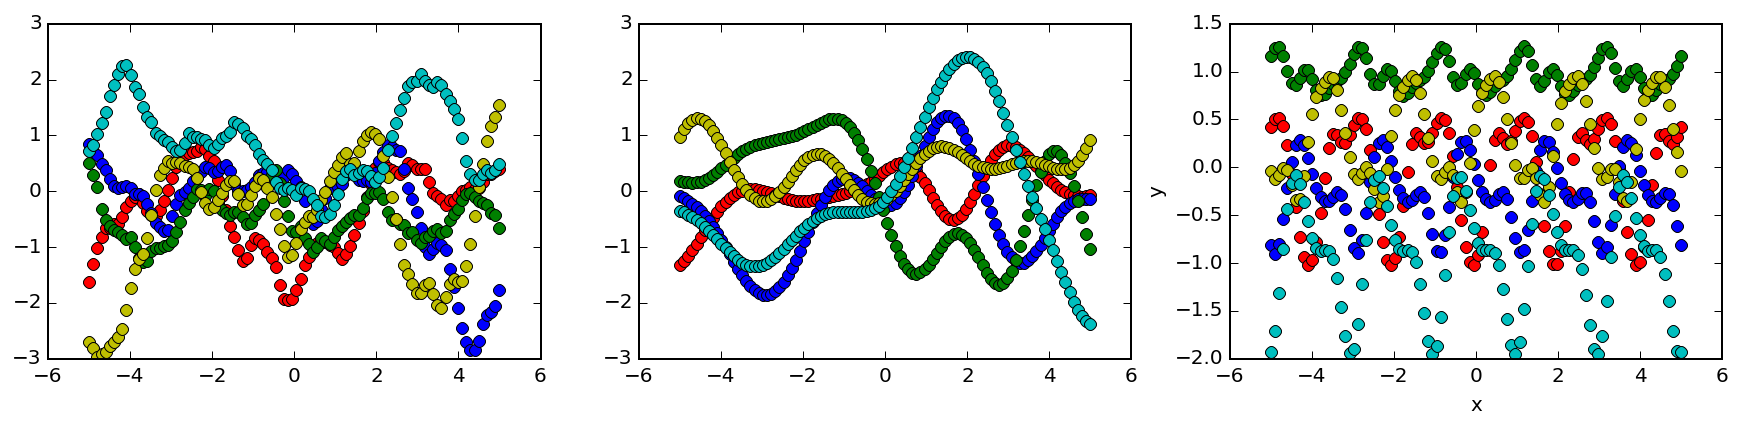

In [93]:
test_x = np.linspace(-5,5,100)
colors = ['ro','bo','go','yo','co']
fig, ax = pl.subplots(ncols=3,nrows=1,sharex=True,figsize=[5*3,3])
pl.xlabel('x')
pl.ylabel('y')
for i in range(5):
    tmp = gp_matern32.sample(test_x)
    ax[0].plot(test_x,tmp,colors[i])
    tmp = gp_SE.sample(test_x)
    ax[1].plot(test_x,tmp,colors[i])
    tmp = gp_per.sample(test_x)
    ax[2].plot(test_x,tmp,colors[i])


Condicionemos el proceso con un set de datos observados

<Container object of 3 artists>

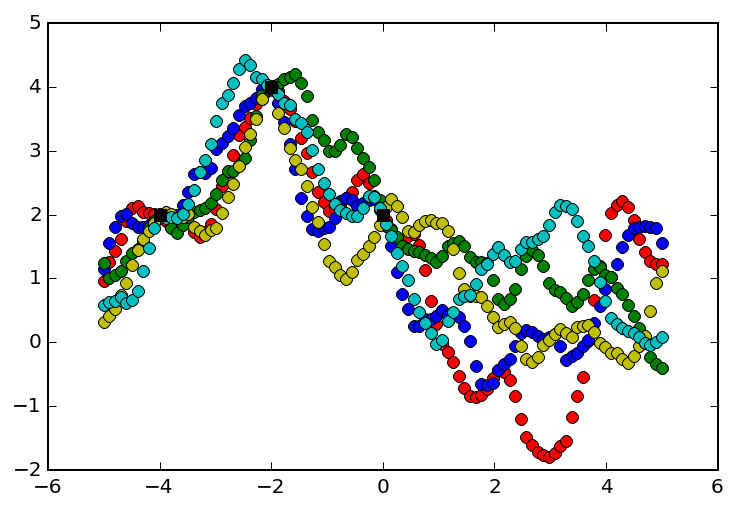

In [113]:
test_t = np.array([-4,-2,0])
test_yerr = 0.001
test_y = np.array([2,4,2])
gp_matern32.compute(test_t,test_yerr)
for i in range(5):
    tmp = gp_matern32.sample_conditional(test_y,test_x)
    pl.plot(test_x,tmp,colors[i])
pl.errorbar(test_t,test_y,yerr=test_yerr,fmt='ks')


# como aprendemos parametros: maximizando el 'marginal likelihood'

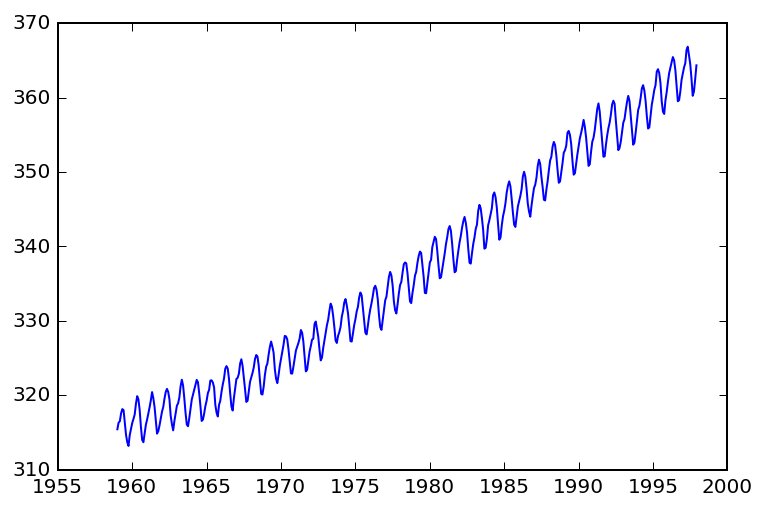

In [71]:
import statsmodels.api as sm
data = sm.datasets.get_rdataset("co2").data
t = np.array(data.time)
y = np.array(data.co2)
pl.plot(t,y,'-')

Estos datos son las mediciones de CO$_2$ medidas en Mauna Loa, Hawaii. Es claramente una señal (quasi) periodica con periodo de un año superpuesto en un trend.

Los modelaremos con una suma de kernels $k(r) = k_1(r) + k_2(r) + k_3(r) + k_4(r)$ con

$k_1(r) = \theta_1^2 \exp(-r^2/2\theta_2^2)$

$k_2(r) = \theta_3^2\exp(-r^2/2\theta_4^2 - \theta_5\sin^2(\pi r/\theta_6))$

$k_3(r) = \theta_7^2[1+r^2/2\theta_8\theta_9]^{\theta_8}$

$k_4(r) = \theta_{10}^2\exp(-r^2/2\theta_{11}) + \theta_{12}^2\delta_{ij}$

In [72]:
k1 = 66.0**2 * kernels.ExpSquaredKernel(67.0**2)
k2 = 2.4**2 * kernels.ExpSquaredKernel(90**2) * kernels.ExpSine2Kernel(2.0 / 1.3**2, 1.0)
k3 = 0.66**2 * kernels.RationalQuadraticKernel(0.78, 1.2**2)
k4 = 0.18**2 * kernels.ExpSquaredKernel(1.6**2) + kernels.WhiteKernel(0.19)
kernel = k1 + k2 + k3 + k4

In [73]:
import george
gp = george.GP(kernel, mean=np.mean(y))
gp.compute(t)
print(gp.lnlikelihood(y))
print(gp.grad_lnlikelihood(y))

-218.354745845
[  2.65662807e-01  -2.28274515e+00  -9.68178058e-01   1.81185617e+00
  -2.79086427e+00  -1.43826996e+03  -3.54416393e+00  -2.93193395e-02
   3.20390608e+00  -2.03185241e-01   7.70274499e-02  -1.42178195e+02]


In [74]:
import scipy.optimize as op

# Define the objective function (negative log-likelihood in this case).
def nll(p):
    # Update the kernel parameters and compute the likelihood.
    gp.kernel[:] = p
    ll = gp.lnlikelihood(y, quiet=True)

    # The scipy optimizer doesn't play well with infinities.
    return -ll if np.isfinite(ll) else 1e25

# And the gradient of the objective function.
def grad_nll(p):
    # Update the kernel parameters and compute the likelihood.
    gp.kernel[:] = p
    return -gp.grad_lnlikelihood(y, quiet=True)

# You need to compute the GP once before starting the optimization.
gp.compute(t)

# Print the initial ln-likelihood.
print(gp.lnlikelihood(y))

# Run the optimization routine.
p0 = gp.kernel.vector
results = op.minimize(nll, p0, jac=grad_nll)

# Update the kernel and print the final log-likelihood.
gp.kernel[:] = results.x
print(gp.lnlikelihood(y))

-218.354745845
-82.4628864455


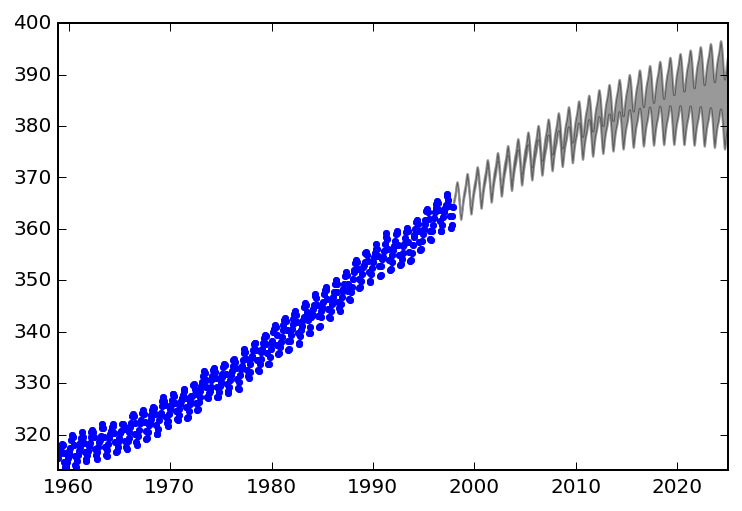

In [75]:
x = np.linspace(max(t), 2025, 2000)
mu, cov = gp.predict(y, x)
std = np.sqrt(np.diag(cov))
fig, ax = pl.subplots()
ax.fill_between(x, mu+std, mu-std, color="k", alpha=0.4)
ax.set_xlim(min(t), 2025.0)
ax.set_ylim(min(y), 400.0)
ax.plot(t,y,'.')

but that forecast does not take into account the uncertainty in the parameters!

In [76]:
def lnprob(p):
    # Trivial improper prior: uniform in the log.
    if np.any((-10 > p) + (p > 10)):
        return -np.inf
    lnprior = 0.0

    # Update the kernel and compute the lnlikelihood.
    kernel.pars = np.exp(p)
    return lnprior + gp.lnlikelihood(y, quiet=True)

In [77]:
import emcee

# You need to compute the GP once before starting. Then the sample list
# will be saved.
gp.compute(t)

# Set up the sampler.
nwalkers, ndim = 36, len(kernel)
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

# Initialize the walkers.
p0 = [np.log(kernel.pars) + 1e-4 * np.random.randn(ndim)
      for i in range(nwalkers)]

print("Running burn-in")
p0, _, _ = sampler.run_mcmc(p0, 2000)

print("Running production chain")
sampler.run_mcmc(p0, 2000)
chain = sampler.chain

Running burn-in
Running production chain


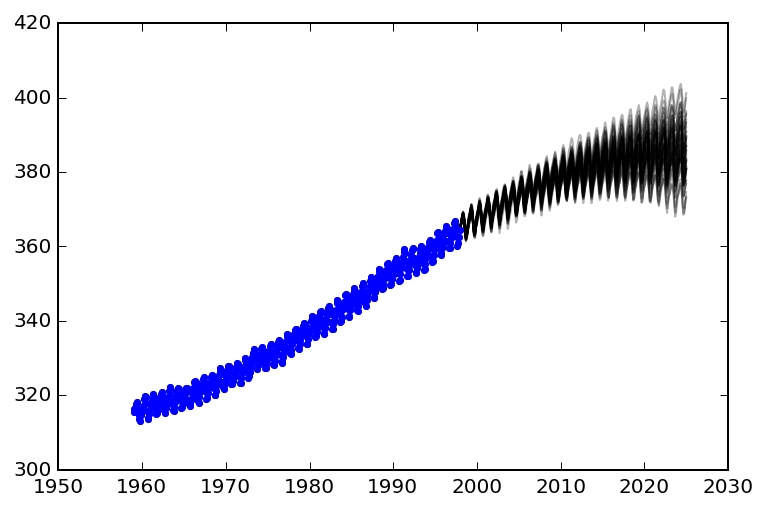

In [78]:
x = np.linspace(max(t), 2025, 250)
for i in range(50):
    # Choose a random walker and step.
    w = np.random.randint(chain.shape[0])
    n = np.random.randint(2000, chain.shape[1])
    gp.kernel.pars = np.exp(chain[w, n])

    # Plot a single sample.
    pl.plot(x, gp.sample_conditional(y, x), "k", alpha=0.3)
pl.plot(t,y,'.')